In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('houses.csv')

# Drop missing values
df = df.dropna()

# Print the number of rows after dropping missing values
print("\nNumber of rows after dropping missing values:", len(df))

# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"\nNumber of duplicate rows: {len(duplicate_rows)}")

# Drop duplicate rows (if any)
df = df.drop_duplicates()

# Print the number of rows after dropping duplicates
print("\nNumber of rows after dropping duplicate rows:", len(df))


Number of rows after dropping missing values: 21613

Number of duplicate rows: 0

Number of rows after dropping duplicate rows: 21613


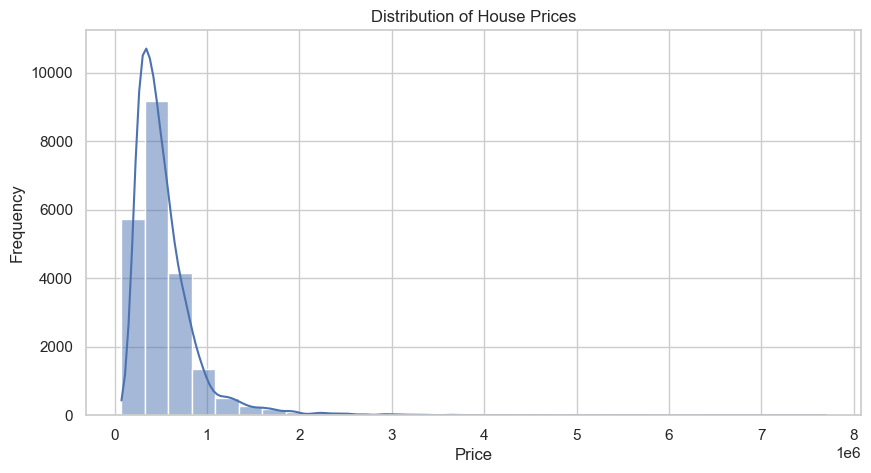

<Figure size 1200x1000 with 0 Axes>

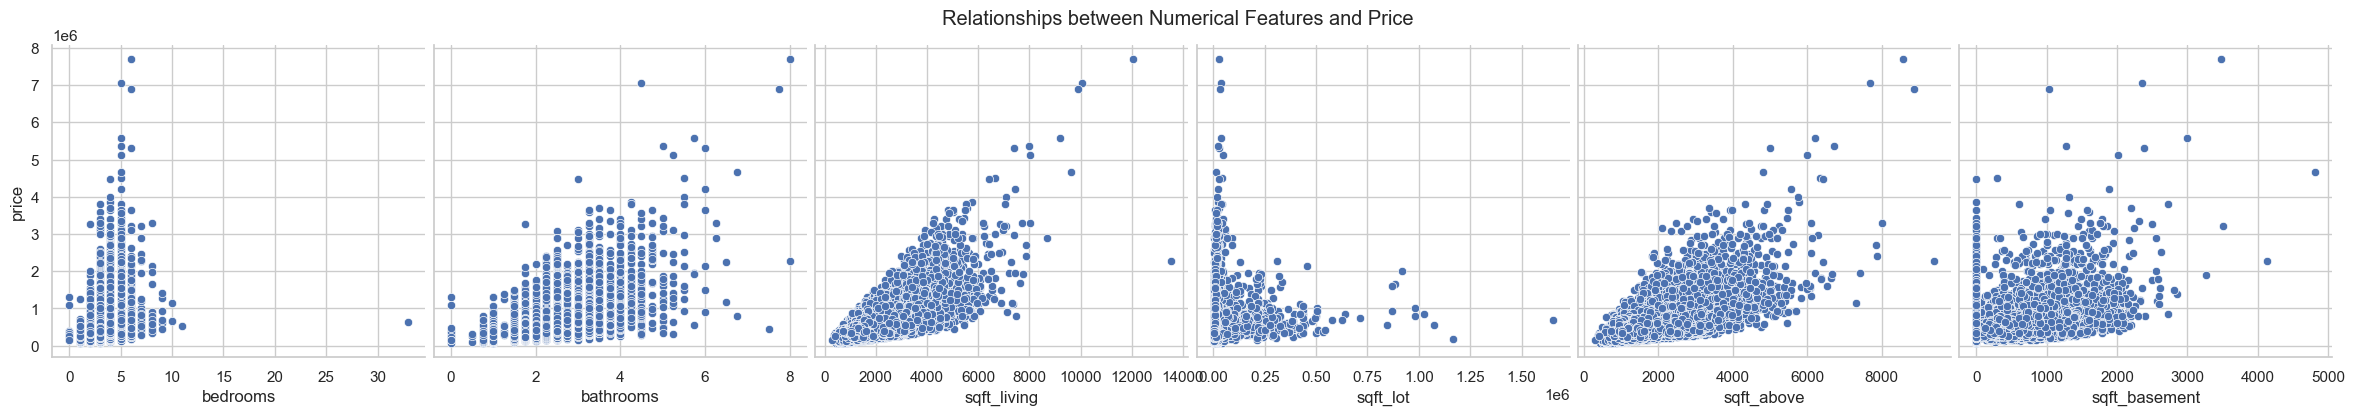

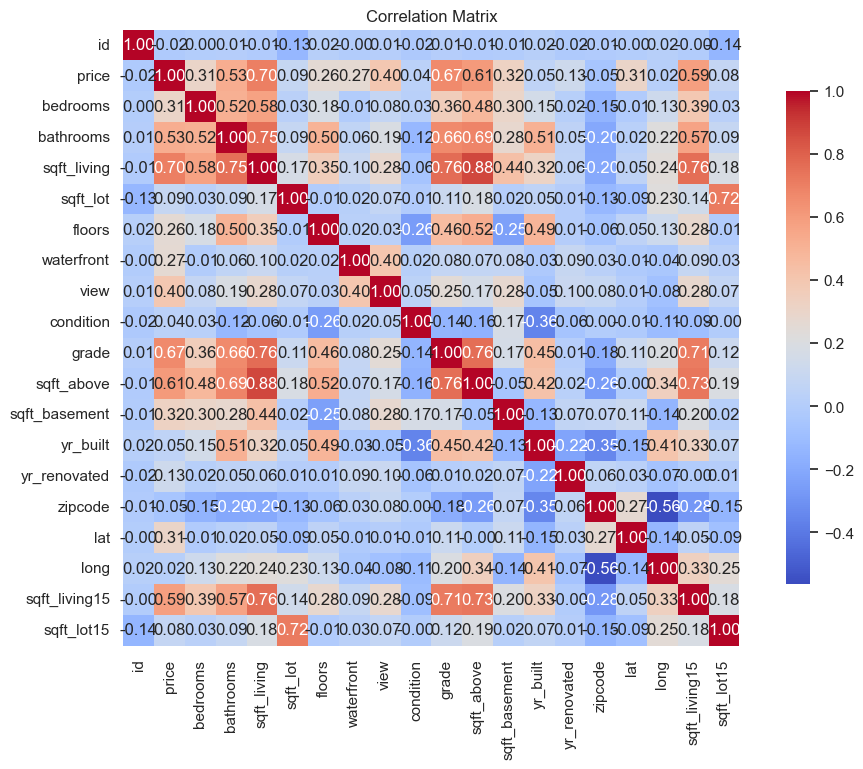

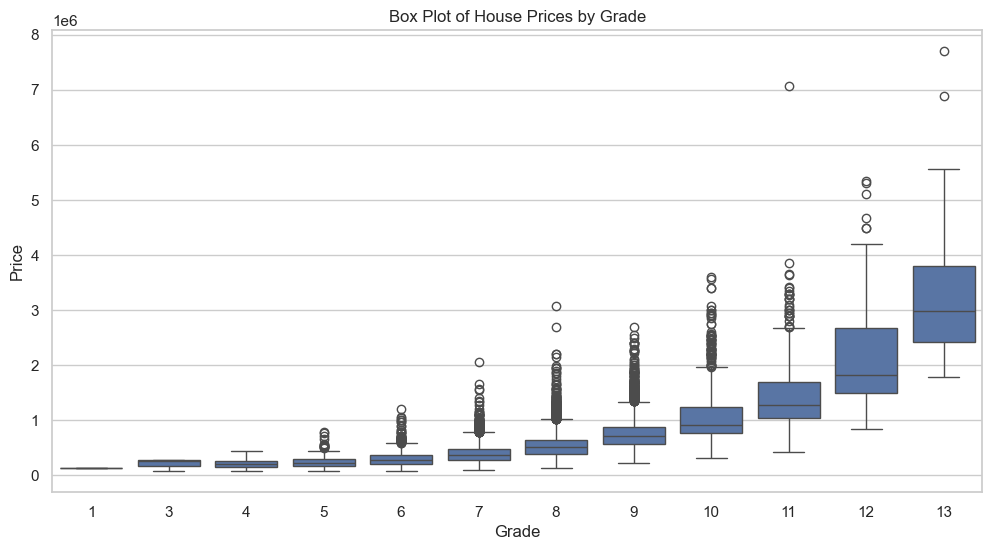

In [3]:
# EDA: Exploratory Data Analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Check the distribution of the target variable (price)
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=30, kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Visualize relationships between numerical features and the target variable
plt.figure(figsize=(12, 10))
sns.pairplot(df, x_vars=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement'], 
             y_vars=['price'], height=4, aspect=1, kind='scatter')
plt.suptitle("Relationships between Numerical Features and Price", y=1.02)
plt.show()

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])  # Select only numeric columns
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='grade', y='price', data=df)
plt.title("Box Plot of House Prices by Grade")
plt.xlabel("Grade")
plt.ylabel("Price")
plt.show()

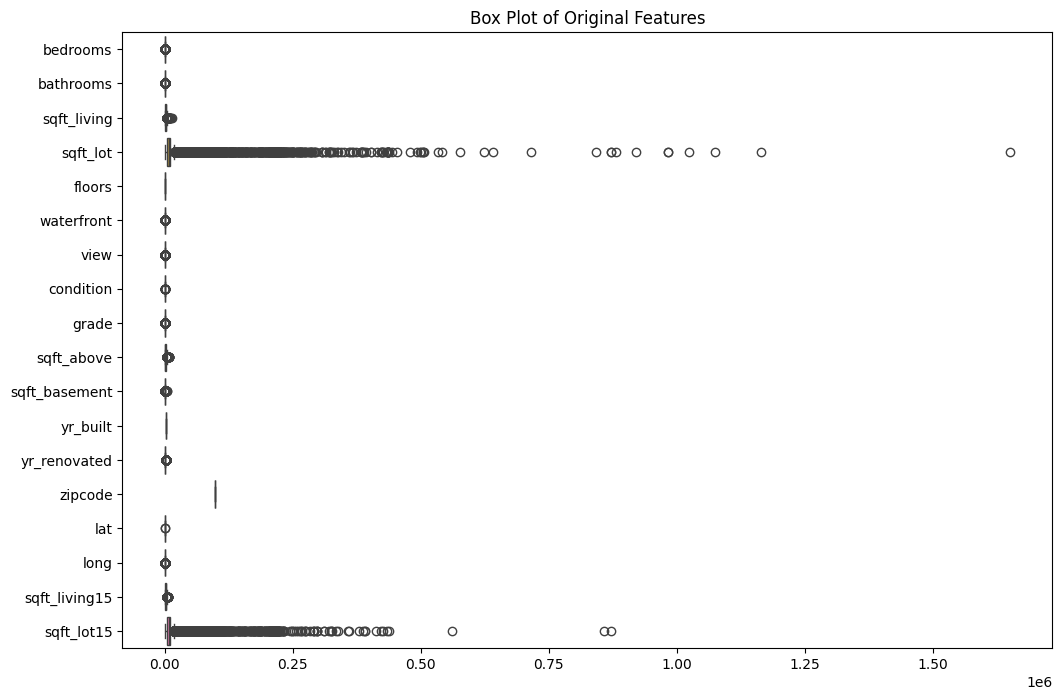

Data shape after outlier removal: (15070, 18)


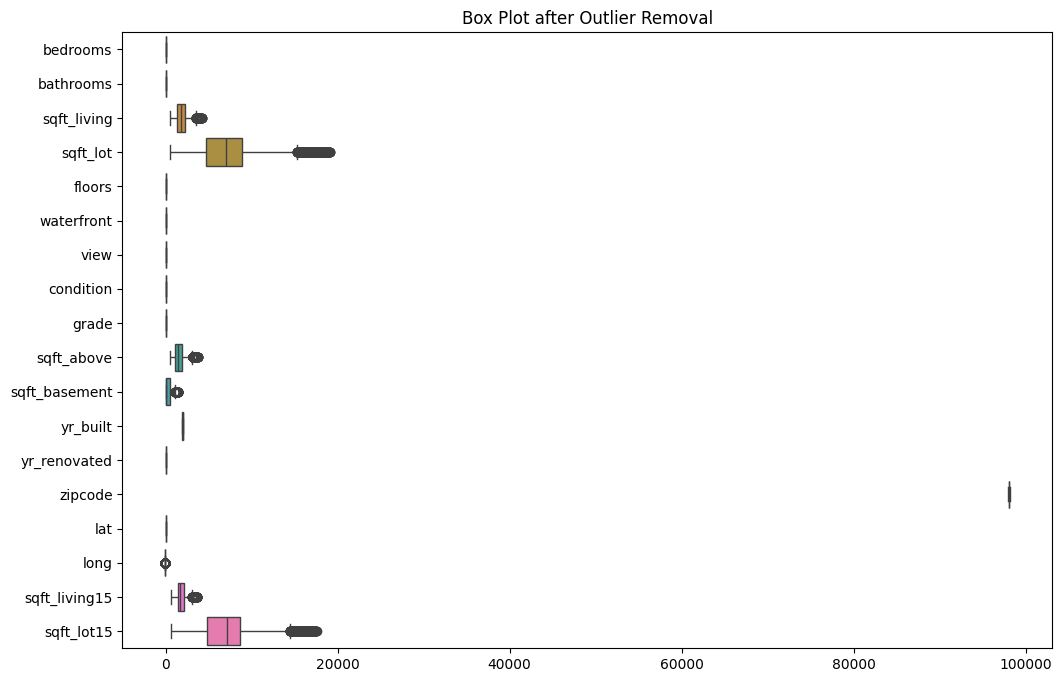

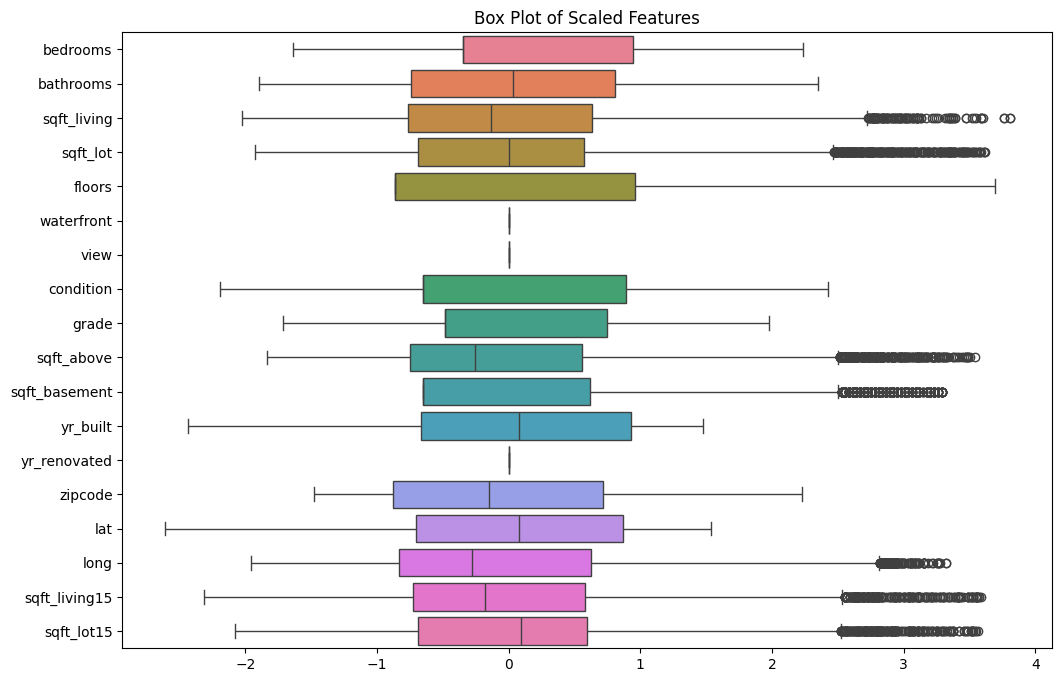

Data has been scaled.
Scaled data saved to 'scaled_houses.csv'.


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('houses.csv')

# Select the features to scale (excluding 'id', 'date', 'price')
features_to_check = df.drop(['id', 'date', 'price'], axis=1)

# Box plots to check the original data distribution
plt.figure(figsize=(12, 8))
sns.boxplot(data=features_to_check, orient="h")
plt.title("Box Plot of Original Features")
plt.show()

# Function to remove outliers using IQR method
def remove_outliers_iqr(data):
    """Removes outliers based on the IQR method."""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    # Filtering out the outliers
    return data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Remove outliers from the data
cleaned_data = remove_outliers_iqr(features_to_check)

# Check how many rows are remaining after removing outliers
print(f"Data shape after outlier removal: {cleaned_data.shape}")

# Box plots after outlier removal
plt.figure(figsize=(12, 8))
sns.boxplot(data=cleaned_data, orient="h")
plt.title("Box Plot after Outlier Removal")
plt.show()

# Perform Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cleaned_data)

# Create a DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=cleaned_data.columns)

# Add the target variable (price) to the scaled DataFrame, ensuring alignment
scaled_df['price'] = df.loc[cleaned_data.index, 'price'].values

# Box plots after scaling
plt.figure(figsize=(12, 8))
sns.boxplot(data=scaled_df.drop('price', axis=1), orient="h")  # Drop price for box plot
plt.title("Box Plot of Scaled Features")
plt.show()

print("Data has been scaled.")

# Save the scaled DataFrame to a CSV file
scaled_df.to_csv('scaled_houses.csv', index=False)
print("Scaled data saved to 'scaled_houses.csv'.")

Best Ridge Parameters: {'alpha': 100.0, 'fit_intercept': True}


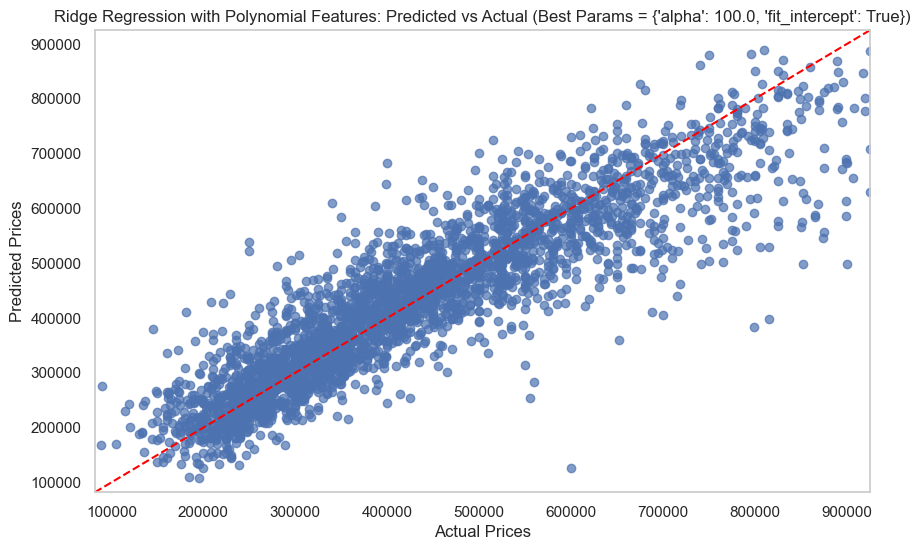

Ridge Regression Model MSE: 5592379194.47
Ridge Regression Model MAE: 54136.69
Ridge Regression Model R^2: 0.80

Highest Price After Removing Outliers: 925000.00
Lowest Price After Removing Outliers: 82000.00
Average Price After Removing Outliers: 430881.96

Training Set MSE (Ridge): 4709854552.03
Training Set R^2 (Ridge): 0.83
Testing Set MSE (Ridge): 5592379194.47
Testing Set R^2 (Ridge): 0.80


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

# Load the normalized dataset
normalized_df = pd.read_csv('scaled_houses.csv')

# Detect outliers in the target variable 'price' using IQR
Q1 = normalized_df['price'].quantile(0.25)  # 25th percentile (Q1)
Q3 = normalized_df['price'].quantile(0.75)  # 75th percentile (Q3)
IQR = Q3 - Q1                               # Interquartile range (IQR)

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers based on the price column
filtered_df = normalized_df[(normalized_df['price'] >= lower_bound) & (normalized_df['price'] <= upper_bound)]

# Use the normalized features for training the models
X = filtered_df.drop(['price'], axis=1)  # Features (normalized)
y = filtered_df['price']               # Target variable (price)

# Create polynomial features
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Set up the parameter grid for Ridge Regression
ridge_params = {
    'alpha': [100.0],  # Range of regularization strength
    'fit_intercept': [True, False],
}

# Initialize the Ridge Regression model
ridge_model = Ridge()

# Perform grid search using 5-fold cross-validation
grid_search_ridge = GridSearchCV(ridge_model, ridge_params, cv=5, scoring='r2')

# Fit the model
grid_search_ridge.fit(X_train, y_train)

# Get the best parameters
best_ridge_params = grid_search_ridge.best_params_
print(f"Best Ridge Parameters: {best_ridge_params}")

# Get the best Ridge Regression model based on GridSearchCV
best_ridge_model = grid_search_ridge.best_estimator_

# Make predictions using the best Ridge model
y_pred_ridge = best_ridge_model.predict(X_test)

# Calculate performance metrics for Ridge regression
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Calculate performance metrics on the training set
y_train_pred_ridge = best_ridge_model.predict(X_train)
mse_train_ridge = mean_squared_error(y_train, y_train_pred_ridge)
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)

# Plot predicted vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')  # Diagonal line
plt.title(f"Ridge Regression with Polynomial Features: Predicted vs Actual (Best Params = {best_ridge_params})")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.grid()
plt.show()

# Print Ridge model performance
print(f"Ridge Regression Model MSE: {mse_ridge:.2f}")
print(f"Ridge Regression Model MAE: {mae_ridge:.2f}")
print(f"Ridge Regression Model R^2: {r2_ridge:.2f}")

# Output the highest, lowest, and average price after removing outliers
highest_price_after_removal = filtered_df['price'].max()
lowest_price_after_removal = filtered_df['price'].min()
average_price_after_removal = filtered_df['price'].mean()

print(f"\nHighest Price After Removing Outliers: {highest_price_after_removal:.2f}")
print(f"Lowest Price After Removing Outliers: {lowest_price_after_removal:.2f}")
print(f"Average Price After Removing Outliers: {average_price_after_removal:.2f}")

print(f"\nTraining Set MSE (Ridge): {mse_train_ridge:.2f}")
print(f"Training Set R^2 (Ridge): {r2_train_ridge:.2f}")
print(f"Testing Set MSE (Ridge): {mse_ridge:.2f}")
print(f"Testing Set R^2 (Ridge): {r2_ridge:.2f}")


Best Hyperparameters: {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


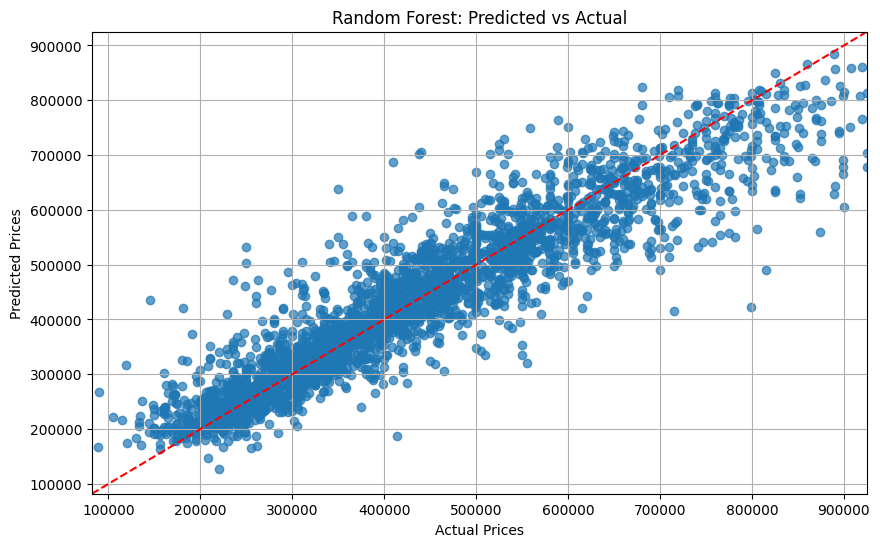

Random Forest Model MSE: 3969312912.16
Random Forest Model MAE: 44153.69
Random Forest Model R^2: 0.86

Highest Price After Removing Outliers: 925000.00
Lowest Price After Removing Outliers: 82000.00
Average Price After Removing Outliers: 430881.96


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the normalized dataset
normalized_df = pd.read_csv('scaled_houses.csv')  # Ensure this is the correct file name

# Detect outliers in the target variable 'price' using IQR
Q1 = normalized_df['price'].quantile(0.25)  # 25th percentile (Q1)
Q3 = normalized_df['price'].quantile(0.75)  # 75th percentile (Q3)
IQR = Q3 - Q1                               # Interquartile range (IQR)

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers based on the price column
filtered_df = normalized_df[(normalized_df['price'] >= lower_bound) & (normalized_df['price'] <= upper_bound)]

# Define features and target variable
X = filtered_df.drop('price', axis=1)  # Features (normalized)
y = filtered_df['price']               # Target variable (price)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the parameter grid for Random Forest Regressor
param_grid = {
    'n_estimators': [200],  
    'max_depth': [20],         
    'min_samples_split': [2],   
    'min_samples_leaf': [1],      
    'max_features': [0.5]  
}

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Perform grid search using 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best Random Forest model based on GridSearchCV
best_rf_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred_rf_test = best_rf_model.predict(X_test)    # Predictions on the testing set

# Calculate performance metrics for the testing set
mse_rf_test = mean_squared_error(y_test, y_pred_rf_test)
mae_rf_test = mean_absolute_error(y_test, y_pred_rf_test)
r2_rf_test = r2_score(y_test, y_pred_rf_test)

# Plot predicted vs actual prices for testing set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf_test, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')  # Diagonal line
plt.title("Random Forest: Predicted vs Actual")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.grid()
plt.show()

# Print Random Forest model performance
print(f"Random Forest Model MSE: {mse_rf_test:.2f}")
print(f"Random Forest Model MAE: {mae_rf_test:.2f}")
print(f"Random Forest Model R^2: {r2_rf_test:.2f}")

# Output the highest, lowest, and average price after removing outliers
highest_price_after_removal = filtered_df['price'].max()
lowest_price_after_removal = filtered_df['price'].min()
average_price_after_removal = filtered_df['price'].mean()

print(f"\nHighest Price After Removing Outliers: {highest_price_after_removal:.2f}")
print(f"Lowest Price After Removing Outliers: {lowest_price_after_removal:.2f}")
print(f"Average Price After Removing Outliers: {average_price_after_removal:.2f}")